## Import Statements

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from catboost import CatBoostRegressor


## Read in Data

In [2]:
df = pd.read_csv('../../data/preprocessed_log_data.csv')
df = df[df['Label'] == 1];
df.drop(columns=['Label', 'TaskName', 'IsHybrid', 'Transmission', 'Odometer'], inplace=True) # Drop TaskName as all are 'Logbook'
df.head()

,Make,Model,Year,FuelType,EngineSize,DriveType,Distance,Months,AdjustedPrice
1,SKODA,SKODA FABIA III,2017,Petrol,1.0,NaN,75000.0,60.0,703.0
4,MAZDA,MAZDA CX-9,2018,Petrol,2.5,2WD,80000.0,96.0,581.0
5,MAZDA,MAZDA 3,2017,Petrol,2.0,NaN,60000.0,72.0,380.0
6,TOYOTA,TOYOTA HILUX,2015,Diesel,2.8,4WD,60000.0,36.0,473.0
8,FORD,FORD RANGER,2021,Diesel,2.0,4WD,45000.0,36.0,650.0


In [3]:
X = df.drop(columns=["AdjustedPrice"])  
y = df["AdjustedPrice"]       

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [70]:
print(X_test['Model'].unique().size)

271


In [20]:
# Identify feature types
cat_features = X_train.select_dtypes(include=["object", "category"]).columns
print(cat_features)

Index(['Make', 'Model', 'FuelType', 'DriveType'], dtype='object')


In [ ]:
for col in X_train.select_dtypes(include='object').columns:
     X_train[col] = X_train[col].fillna("missing")

for col in X_test.select_dtypes(include='object').columns:
     X_test[col] = X_test[col].fillna("missing")

In [7]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    # Avoid division by zero
    nonzero_mask = y_true != 0
    return np.mean(np.abs((y_true[nonzero_mask] - y_pred[nonzero_mask]) / y_true[nonzero_mask])) * 100

In [9]:
cat_feature_indices = [0, 1, 3, 5]

model = CatBoostRegressor(
    cat_features=cat_feature_indices,
    eval_metric='MAPE',
    od_type='Iter',
    od_wait=50,
    random_seed=42,
    verbose=100
)

model.fit(X_train, y_train, 
                  verbose=False)



In [ ]:
y_pred = model.predict(X_test)

def top_n_accuracy(y_true, y_pred):
    
    errors = np.abs(y_true - y_pred)

    results = pd.DataFrame({
        "y_true": y_true,
        "y_pred": y_pred,
        "error": errors  })

    sorted_results = results.sort_values(by="error")
    top5_accurate = sorted_results.head(5)
    top5_inaccurate = sorted_results.tail(5)

    print("Top 5 Most Accurate Predictions:")
    print(top5_accurate)

    print("\nTop 5 Least Accurate Predictions:")
    print(top5_inaccurate)

In [51]:
def top_n_categories(y_true, y_pred, features_df, feature_col, top_n=5, error_type="mae"):
    
    df = pd.DataFrame({
      "y_true": y_true,
      "y_pred": y_pred,
      "error": y_true - y_pred
    })

    df[feature_col] = features_df[feature_col].values
    if error_type == "mae":
      df["err"] = df["error"].abs()


    if error_type == "mse":
      df["err"] = df["error"]**2
      


    grouped = df.groupby(feature_col).aggregate(avg_error=("err", "mean"),frequency=("err", "count"))

    sorted = grouped.sort_values("avg_error")
    best = sorted.head(top_n).reset_index()
    worst = sorted.tail(top_n).reset_index()
    
    print("Top 5 Best Categories:")
    print(best)

    print("\nTop 5 Least Accurate Predictions:")
    print(worst)      



In [ ]:
top_n_accuracy(y_test, y_pred)
top_n_categories(y_test, y_pred, X_test, 'Model', error_type="mse")

Top 5 Most Accurate Predictions:
        y_true      y_pred     error
68449    529.0  529.001588  0.001588
13400    496.0  495.996001  0.003999
100114   415.0  414.989110  0.010890
156062   292.0  291.986736  0.013264
139094   425.0  425.018201  0.018201

Top 5 Least Accurate Predictions:
        y_true       y_pred        error
58212   2455.0   765.506541  1689.493459
145775  2770.0  1019.252963  1750.747037
106482  2431.0   622.072874  1808.927126
38900   2805.0   864.464091  1940.535909
129390  2593.0   498.311130  2094.688870
Top 5 Best Categories:
               Model   avg_error  frequency
0  VOLKSWAGEN BEETLE   94.976182          2
1       PEUGEOT 4008  112.846922          1
2        MAZDA MX-30  173.916596          1
3      SUBARU LEVORG  253.493087          3
4   SKODA OCTAVIA IV  592.653619          1

Top 5 Least Accurate Predictions:
                   Model     avg_error  frequency
0                 BMW X5  4.020226e+05         10
1   LAND ROVER DISCOVERY  4.202741e+05    

In [9]:


from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
best_model.fit(X_train, y_train)

y_pred = best_model.predict(X_test)
print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
mape = mean_absolute_percentage_error(y_test, y_pred)
print(f"MAPE: {mape:.2f}%")


0:	learn: 0.3803721	total: 30.3ms	remaining: 30.3s
100:	learn: 0.2685788	total: 820ms	remaining: 7.29s
200:	learn: 0.2430811	total: 1.74s	remaining: 6.93s
300:	learn: 0.2303668	total: 2.67s	remaining: 6.21s
400:	learn: 0.2217592	total: 3.51s	remaining: 5.24s
500:	learn: 0.2158310	total: 4.36s	remaining: 4.34s
600:	learn: 0.2121797	total: 5.18s	remaining: 3.44s
700:	learn: 0.2088783	total: 6.01s	remaining: 2.56s
800:	learn: 0.2063680	total: 6.88s	remaining: 1.71s
900:	learn: 0.2038619	total: 7.73s	remaining: 850ms
999:	learn: 0.2019836	total: 8.57s	remaining: 0us
MAE: 105.20374040609427
RMSE: 166.22007275030643
MAPE: 19.99%


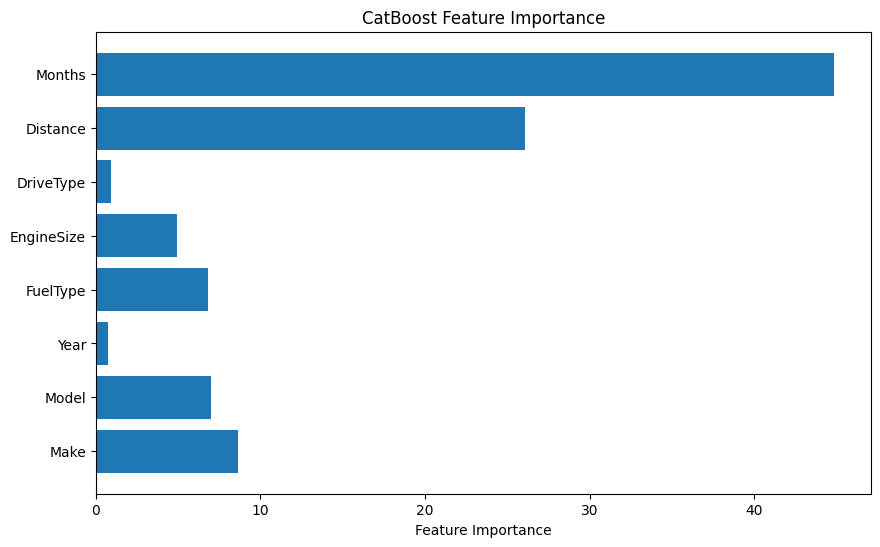

In [10]:
importance = best_model.get_feature_importance()
feature_names = X_train.columns  # or your list of feature names

plt.figure(figsize=(10,6))
plt.barh(feature_names, importance)
plt.xlabel('Feature Importance')
plt.title('CatBoost Feature Importance')
plt.show()